In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import os
import io
import pandas as pd

In [0]:
import torch
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [0]:
!pip install transformers

In [0]:
%cd /content/drive/My Drive/PROJECT - NLP/semantic-segmentation

/content/drive/My Drive/PROJECT - NLP/semantic-segmentation


In [0]:
Documnets = []
with open('categories.txt','r+') as f:
    doc = f.read()
    for fil in doc.split('\n'):
      if len(fil.split('\t')) == 2:
        for names in fil.split('\t')[1].split(" "):
          Documnets.append(names)

In [0]:
%cd /content/drive/My Drive/PROJECT - NLP/semantic-segmentation/data/text/files

/content/drive/My Drive/PROJECT - NLP/semantic-segmentation/data/text/files


In [0]:
from sklearn.model_selection import train_test_split
train_docs , test_docs = train_test_split(Documnets,test_size=0.2)

In [0]:
sent = []
classes = []

for filename in train_docs:
  with io.open(filename+'.txt','r') as f:
    file = f.read()
  for i in range(len(file.split('\n'))):
    if len(file.split('\n')[i].split('\t')) == 2:
      s = file.split('\n')[i].split('\t')[0]
      sent.append(s)
      classes.append(file.split('\n')[i].split('\t')[1])

dic = {'Sentence':sent,'Class':classes}
df2 = pd.DataFrame(dic)

In [0]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

In [0]:
enc.fit(classes)
classes = enc.transform(classes)

In [0]:
df2 = pd.concat([df2,pd.DataFrame(list(classes))],axis = 1)

In [0]:
df2.columns = ['Sentence','Class','Labels']

In [0]:
sentences = df2.Sentence.values
labels = df2.Labels.values

In [0]:
from transformers import BertTokenizer
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [0]:
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  This appeal is by special leave against the judgment and decree of the High Court of Kerala which dismissed an appeal against the judgment and decree of the Subordinate Court of Havelikkara
Token IDs: tensor([  101,  2023,  5574,  2003,  2011,  2569,  2681,  2114,  1996,  8689,
         1998, 10037,  1997,  1996,  2152,  2457,  1997,  8935,  2029,  7219,
         2019,  5574,  2114,  1996,  8689,  1998, 10037,  1997,  1996, 15144,
         2457,  1997,  2031, 18393, 16566,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [0]:
from torch.utils.data import TensorDataset, random_split
dataset = TensorDataset(input_ids, attention_masks, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

6,033 training samples
1,509 validation samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 32
train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )
validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

In [0]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 7,
    output_attentions = False,
    output_hidden_states = False
)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [0]:
import numpy as np
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [0]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

        total_train_loss += loss.item()

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()

        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        

            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...


/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha)


  Batch    40  of    189.    Elapsed: 0:00:25.
  Batch    80  of    189.    Elapsed: 0:00:51.
  Batch   120  of    189.    Elapsed: 0:01:17.
  Batch   160  of    189.    Elapsed: 0:01:42.

  Average training loss: 1.33
  Training epcoh took: 0:02:01

Running Validation...
  Accuracy: 0.59
  Validation Loss: 1.20
  Validation took: 0:00:10

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    189.    Elapsed: 0:00:26.
  Batch    80  of    189.    Elapsed: 0:00:51.
  Batch   120  of    189.    Elapsed: 0:01:17.
  Batch   160  of    189.    Elapsed: 0:01:43.

  Average training loss: 0.96
  Training epcoh took: 0:02:01

Running Validation...
  Accuracy: 0.63
  Validation Loss: 1.08
  Validation took: 0:00:10

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    189.    Elapsed: 0:00:26.
  Batch    80  of    189.    Elapsed: 0:00:51.
  Batch   120  of    189.    Elapsed: 0:01:17.
  Batch   160  of    189.    Elapsed: 0:01:43.

  Average training loss: 0.66
  Training ep

In [0]:
df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.330354,1.195321,0.590234,0:02:01,0:00:10
2,0.959906,1.082128,0.631250,0:02:01,0:00:10
3,0.663102,1.180799,0.623437,0:02:01,0:00:10
4,0.444505,1.193117,0.629948,0:02:01,0:00:10


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


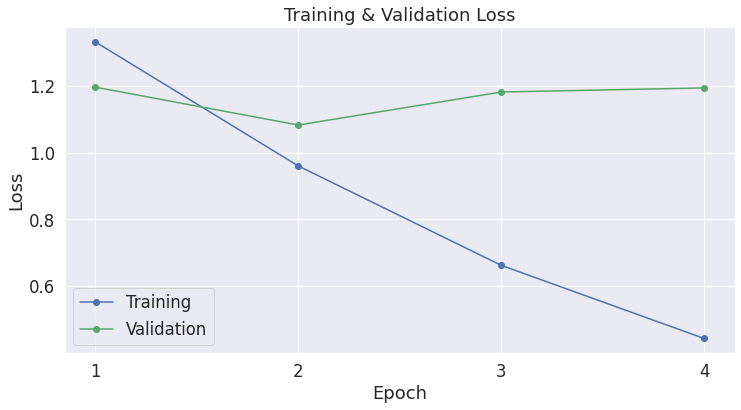

In [0]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [0]:
sent = []
classes = []

for filename in test_docs:
  with io.open(filename+'.txt','r') as f:
    file = f.read()
  for i in range(len(file.split('\n'))):
    if len(file.split('\n')[i].split('\t')) == 2:
      s = file.split('\n')[i].split('\t')[0]
      sent.append(s)
      classes.append(file.split('\n')[i].split('\t')[1])

dic = {'Sentence':sent,'Class':classes}
df1 = pd.DataFrame(dic)

In [0]:
classes = enc.transform(classes)
df1 = pd.concat([df1,pd.DataFrame(list(classes))],axis = 1)
df1.columns = ['Sentence','Class','Labels']
sentences = df1.Sentence.values
labels = df1.Labels.values

In [0]:
input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Leave granted
Token IDs: tensor([ 101, 2681, 4379,  102,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


In [0]:
preds_labels = []
l = len(input_ids)
for i in range(l):
  t = model(input_ids[i].unsqueeze(0).cuda(), attention_mask=attention_masks[i].unsqueeze(0).cuda(),labels=labels[i].unsqueeze(0).cuda())[1]
  preds_labels.append(np.argmax(t.detach().cpu().numpy()))

In [0]:
from sklearn.metrics import classification_report
dic = classification_report(labels,preds_labels, labels=[0,1,2,3,4,5,6], target_names=['Argument', 'Facts', 'Precedent', 'Ratio of the decision','Ruling by Lower Court', 'Ruling by Present Court', 'Statute'], digits=2, output_dict=True, zero_division='warn')
df_report = pd.DataFrame(data = dic)

In [0]:
df_report

,Argument,Facts,Precedent,Ratio of the decision,Ruling by Lower Court,Ruling by Present Court,Statute,accuracy,macro avg,weighted avg
precision,0.680000,0.594080,0.684411,0.505051,0.375000,0.622222,0.710526,0.579521,0.595899,0.593261
recall,0.505952,0.709596,0.443350,0.655738,0.132353,0.466667,0.632812,0.579521,0.506638,0.579521
f1-score,0.580205,0.646720,0.538117,0.570613,0.195652,0.533333,0.669421,0.579521,0.533437,0.572503
support,168.000000,396.000000,406.000000,610.000000,68.000000,60.000000,128.000000,0.579521,1836.000000,1836.000000
